In [14]:
import sys, os
file_dir = os.path.abspath("/home/rodr/code/mobility-baselines/T-GCN-master/T-GCN/T-GCN-PyTorch")
print(file_dir)
sys.path.append(file_dir)

import argparse
import traceback
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_info
import models
import tasks
import utils.callbacks
import utils.data
import utils.logging

import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor


DATA_PATHS = {
    "shenzhen": {"feat": "data/sz_speed.csv", "adj": "data/sz_adj.csv"},
    "losloop": {"feat": "data/los_speed.csv", "adj": "data/los_adj.csv"},
}


def get_model(args, dm):
    model = None
    if args.model_name == "GCN":
        model = models.GCN(adj=dm.adj, input_dim=args.seq_len, output_dim=args.hidden_dim)
    if args.model_name == "GRU":
        model = models.GRU(input_dim=dm.adj.shape[0], hidden_dim=args.hidden_dim)
    if args.model_name == "TGCN":
        model = models.TGCN(adj=dm.adj, hidden_dim=args.hidden_dim)
    return model


def get_task(args, model, dm):
    task = getattr(tasks, args.settings.capitalize() + "ForecastTask")(
        model=model, feat_max_val=dm.feat_max_val, **vars(args)
    )
    return task


def get_callbacks(args):
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="train_loss")
    plot_validation_predictions_callback = utils.callbacks.PlotValidationPredictionsCallback(monitor="train_loss")
    callbacks = [
        checkpoint_callback,
        plot_validation_predictions_callback,
    ]
    return callbacks


def main_supervised(args):
    dm = utils.data.SpatioTemporalCSVDataModule(
        feat_path=DATA_PATHS[args.data]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
    )
    model = get_model(args, dm)
    task = get_task(args, model, dm)
    callbacks = get_callbacks(args)
    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks)
    trainer.fit(task, dm)
    results = trainer.validate(datamodule=dm)
    return results


def main(args):
    rank_zero_info(vars(args))
    results = globals()["main_" + args.settings](args)
    return results


parser = argparse.ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)

parser.add_argument(
    "--data", type=str, help="The name of the dataset", choices=("shenzhen", "losloop"), default="losloop"
)
parser.add_argument(
    "--model_name",
    type=str,
    help="The name of the model for spatiotemporal prediction",
    choices=("GCN", "GRU", "TGCN"),
    default="GCN",
)
parser.add_argument(
    "--settings",
    type=str,
    help="The type of settings, e.g. supervised learning",
    choices=("supervised",),
    default="supervised",
)
parser.add_argument("--log_path", type=str, default=None, help="Path to the output console log file")
parser.add_argument("--send_email", "--email", action="store_true", help="Send email when finished")
parser.add_argument("-f", type=str, default=None)

temp_args, _ = parser.parse_known_args()

parser = getattr(utils.data, temp_args.settings.capitalize() + "DataModule").add_data_specific_arguments(parser)
parser = getattr(models, temp_args.model_name).add_model_specific_arguments(parser)
parser = getattr(tasks, temp_args.settings.capitalize() + "ForecastTask").add_task_specific_arguments(parser)

args = parser.parse_args()
args.pre_len = 4
utils.logging.format_logger(pl._logger)
if args.log_path is not None:
    utils.logging.output_logger_to_file(pl._logger, args.log_path)

dm = utils.data.SpatioTemporalCSVDataModule(
        feat_path=DATA_PATHS["shenzhen"]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
    )

/home/rodr/code/mobility-baselines/T-GCN-master/T-GCN/T-GCN-PyTorch


In [15]:
data = utils.data.functions.load_features(DATA_PATHS["shenzhen"]["feat"])
data.shape

(2976, 156)

In [16]:
2976/(4*24) # data is in 15 minutes intervals, not 5min! 1 month of data

31.0

In [17]:
from workalendar.asia.china import ChineseNewYearCalendar
holidays = [ChineseNewYearCalendar().holidays(y) for y in [2015]][0]
holidays

[(datetime.date(2015, 1, 1), 'New year'),
 (datetime.date(2015, 2, 19), 'Chinese New Year')]

In [18]:
args.split_ratio

0.8

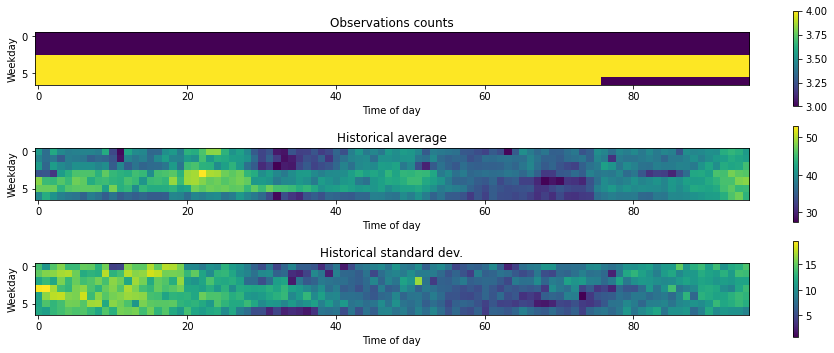

In [19]:
import sys
sys.path.append(os.path.abspath("/home/rodr/code/mobility-baselines"))
import datetime
from mobility_detrender import MobilityDetrender
from evaluation import evaluation

detrender = MobilityDetrender(day_duration=4*24, week_duration=7)
trainset_len = int(args.split_ratio*len(data)) # use only trainset for fitting historical averages
detrender.fit(data[:trainset_len], start_date=datetime.date(2015,1,1), holidays=[])
detrender.visualize(0)

In [20]:
detrended_data = detrender.transform(data, start_date=datetime.date(2015,1,1), holidays=[], mode='avg')
evl_train = evaluation(data, detrender.ha_trend)
print('Residuals of Historical Average (on all data) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 
detrended_data.shape

Residuals of Historical Average (on all data) -> MAPE: 1012456714713.656; MAE:  4.501; RMSE: 6.416


(2976, 156)

In [21]:
# train/val/test split
train_dataset, test_dataset = utils.data.functions.generate_torch_datasets(
                                data,
                                args.seq_len,
                                args.pre_len,
                                split_ratio=args.split_ratio,
                                normalize=False)
train_ha, test_ha = utils.data.functions.generate_torch_datasets(
                                detrender.ha_trend,
                                args.seq_len,
                                args.pre_len,
                                split_ratio=args.split_ratio,
                                normalize=False)

#add time window
x_tra, y_tra = train_dataset.tensors
x_tra, y_tra = x_tra.numpy(), y_tra.numpy()
x_test, y_test = test_dataset.tensors
x_test, y_test = x_test.numpy(), y_test.numpy()
print('Train: ', x_tra.shape, y_tra.shape)
print('Test: ', x_test.shape, y_test.shape)
x_tra_ha, y_tra_ha = train_ha.tensors
x_tra_ha, y_tra_ha = x_tra_ha.numpy(), y_tra_ha.numpy()
x_test_ha, y_test_ha = test_ha.tensors
x_test_ha, y_test_ha = x_test_ha.numpy(), y_test_ha.numpy()
print('Train HA: ', x_tra_ha.shape, y_tra_ha.shape)
print('Test HA: ', x_test_ha.shape, y_test_ha.shape)

Train:  (2364, 12, 156) (2364, 4, 156)
Test:  (580, 12, 156) (580, 4, 156)
Train HA:  (2364, 12, 156) (2364, 4, 156)
Test HA:  (580, 12, 156) (580, 4, 156)


In [22]:
evl_test = evaluation(y_test[:,0,:], y_test_ha[:,0,:])
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

Test set -> MAPE: 4078078787584.000; MAE:  4.629; RMSE: 6.462


In [23]:
steps_ahead = 0 # number of step-ahead for prediction (0=15min, 1=30min, 2=45min, 3=60min)

all_preds = []
all_trues = []
for loc in range(data.shape[1]):
    # prepare input data
    x = x_tra[:, :, loc] - x_tra_ha[:, :, loc] # detrend input data for training
    y = y_tra[:, steps_ahead, loc] - y_tra_ha[:, steps_ahead, loc] # detrend targets for training

    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)

    # predict on test set
    trues = y_test[:, steps_ahead, loc] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(x_test[:, :, loc] - x_test_ha[:, :, loc]) # make predictions on detrended inputs
    preds = preds + y_test_ha[:, steps_ahead, loc] # convert preds back to original scale (revert detrending)

    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(580, 156)
(580, 156)
Test set -> MAPE: 4676026630144.000; MAE:  3.464; RMSE: 4.998


In [24]:
steps_ahead = 1 # number of step-ahead for prediction (0=15min, 1=30min, 2=45min, 3=60min)

all_preds = []
all_trues = []
for loc in range(data.shape[1]):
    # prepare input data
    x = x_tra[:, :, loc] - x_tra_ha[:, :, loc] # detrend input data for training
    y = y_tra[:, steps_ahead, loc] - y_tra_ha[:, steps_ahead, loc] # detrend targets for training

    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)

    # predict on test set
    trues = y_test[:, steps_ahead, loc] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(x_test[:, :, loc] - x_test_ha[:, :, loc]) # make predictions on detrended inputs
    preds = preds + y_test_ha[:, steps_ahead, loc] # convert preds back to original scale (revert detrending)

    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(580, 156)
(580, 156)
Test set -> MAPE: 4253054140416.000; MAE:  3.507; RMSE: 5.057


In [25]:
steps_ahead = 2 # number of step-ahead for prediction (0=15min, 1=30min, 2=45min, 3=60min)

all_preds = []
all_trues = []
for loc in range(data.shape[1]):
    # prepare input data
    x = x_tra[:, :, loc] - x_tra_ha[:, :, loc] # detrend input data for training
    y = y_tra[:, steps_ahead, loc] - y_tra_ha[:, steps_ahead, loc] # detrend targets for training

    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)

    # predict on test set
    trues = y_test[:, steps_ahead, loc] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(x_test[:, :, loc] - x_test_ha[:, :, loc]) # make predictions on detrended inputs
    preds = preds + y_test_ha[:, steps_ahead, loc] # convert preds back to original scale (revert detrending)

    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(580, 156)
(580, 156)
Test set -> MAPE: 4231681802240.000; MAE:  3.534; RMSE: 5.091


In [28]:
steps_ahead = 3 # number of step-ahead for prediction (0=15min, 1=30min, 2=45min, 3=60min)

all_preds = []
all_trues = []
for loc in range(data.shape[1]):
    # prepare input data
    x = x_tra[:, :, loc] - x_tra_ha[:, :, loc] # detrend input data for training
    y = y_tra[:, steps_ahead, loc] - y_tra_ha[:, steps_ahead, loc] # detrend targets for training

    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)

    # predict on test set
    trues = y_test[:, steps_ahead, loc] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(x_test[:, :, loc] - x_test_ha[:, :, loc]) # make predictions on detrended inputs
    preds = preds + y_test_ha[:, steps_ahead, loc] # convert preds back to original scale (revert detrending)

    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(580, 156)
(580, 156)
Test set -> MAPE: 4346771406848.000; MAE:  3.554; RMSE: 5.115
